In [1]:
import math
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tiktoken
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from torchsummaryX import summary
import wandb
from dataclasses import dataclass
from tqdm import tqdm

In [2]:
# set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
cudnn.deterministic = True
cudnn.benchmark = False

# Hyperparameters

In [3]:
@dataclass
class IDeaLGPTConfig:

    # General
    batch_size: int = 64
    gradient_accumulation_steps: int = 4
    num_iters: int = 10000
    eval_iters: int = 3
    eval_interval: int = 1000
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Model
    sequence_length: int = 256
    vocab_size: int = 50257 # gpt2 vocab
    num_blocks: int = 8
    num_heads: int = 8
    embed_dim: int = 512
    dropout: float = 0.1
    bias: bool = False 

    # Data
    num_workers: int = 8
    train_test_split: float = 0.8
    SUBSET_PERCENTAGE: float =0.01 # % of OWT to train on, between 0 and 1

    # LR scheduler
    lr: float = 2e-3
    lr_decay: bool = True
    warmup_iters: int = 1000
    min_lr: float = 6e-6

    # optimizer
    weight_decay: float = 1e-1
    grad_clip: float = 1.0
    

config = IDeaLGPTConfig()
device = config.device
config

IDeaLGPTConfig(batch_size=64, gradient_accumulation_steps=4, num_iters=10000, eval_iters=3, eval_interval=1000, device='cuda', sequence_length=256, vocab_size=50257, num_blocks=8, num_heads=8, embed_dim=512, dropout=0.1, bias=False, num_workers=8, train_test_split=0.8, SUBSET_PERCENTAGE=0.01, lr=0.002, lr_decay=True, warmup_iters=1000, min_lr=6e-06, weight_decay=0.1, grad_clip=1.0)

In [4]:
print(f'Effective batch size = {config.batch_size * config.gradient_accumulation_steps}')

Effective batch size = 256


# Loading Data and Preprocessing

In [5]:
# hf_dataset = load_dataset("Skylion007/openwebtext", split='train') # only has one split - train
# hf_dataset = hf_dataset.with_format("torch")
# hf_dataset

In [6]:
# # data = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * SUBSET_PERCENTAGE)))
# # hf_dataset = hf_dataset.select(range(int(len(hf_dataset) * config.SUBSET_PERCENTAGE)))
# hf_dataset = hf_dataset.train_test_split(train_size=config.train_test_split)
# hf_dataset

In [7]:
# train_hf_dataset, val_hf_dataset = hf_dataset['train'], hf_dataset['test']

## Tokenizer - OpenAI tiktoken

In [8]:
# # tokenizer = tiktoken.get_encoding("cl100k_base") # gpt4 tokenizer - NOTE: need to change vocab_size in config if used
tokenizer = tiktoken.encoding_for_model('gpt-2')


tokenizer.encode('hello world')

[31373, 995]

In [9]:
# vocab_size = tokenizer.n_vocab
# config.vocab_size = vocab_size
# vocab_size

In [10]:
# def tokenize_function(batch):
#     # The 'text' field in the batch is a list of strings.
#     texts = batch['text']
#     # Tokenize each text in the list.
#     return {'tokens': tokenizer.encode_batch(texts)}

In [11]:
# tokenized_train_hf_dataset  = train_hf_dataset.map(tokenize_function, batched=True, batch_size=1000)
# tokenized_val_hf_dataset = val_hf_dataset.map(tokenize_function, batched=True, batch_size=1000)

In [12]:
# tokenized_train_hf_dataset

## Pytorch Dataset

In [13]:
# config.sequence_length = 256

In [14]:
# class NextTokenPredictionDataset(Dataset):
#     def __init__(self, hf_dataset, config):
#         self.hf_dataset = hf_dataset['tokens'] # we don't care about text
#         self.sequence_length = config.sequence_length

#     def __len__(self):
#         return len(self.hf_dataset)

#     def __getitem__(self, i):
#         doc_tokens = self.hf_dataset[i] # any random document is selected
#         max_idx = max(0, len(doc_tokens) - self.sequence_length) # Ensuring the index is non-negative
#         idx = torch.randint(max_idx+1, (1, ))
#         x = doc_tokens[idx:idx+self.sequence_length]
#         y = doc_tokens[idx+1:idx+self.sequence_length+1]
#         return x, y

In [15]:
# train_dataset = NextTokenPredictionDataset(tokenized_train_hf_dataset, config)
# val_dataset = NextTokenPredictionDataset(tokenized_val_hf_dataset, config)

In [16]:
# train_dataset.__getitem__(54785)

In [17]:
# def sanity_min_len():
#     ml = 1e9
#     mli = -1
#     for i in range(len(train_dataset)):
#         cl = len(train_dataset[i][0])
#         if cl < ml:
#             ml = cl
#             mli = i
#     print(ml, mli)
        
# sanity_min_len()

In [18]:
# def sanity_data(train_dataset):
#     tmp = train_dataset[0]
#     print(tmp, len(tmp[0]), tokenizer.decode(tmp[0].tolist()))
# sanity_data(train_dataset)

## Dataloader

In [19]:
# train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=1)
# val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

In [20]:
# for x, y in train_loader:
#     print(x.shape, y.shape)
#     break

In [21]:
# poor man's dataloader
# but actual motivation is - im too lazy to write and deal with pad tokens in above method to read data
# since there are documents which are less than sequence length and they mess up the batch
# this method is cleaner, i get to learn something new (np.memmap!) and it's fun!

data_dir = os.path.join('data', 'owt')

def get_batch(split):
    file_path = os.path.join(data_dir, 'val' if split == 'val.bin' else 'train.bin')
    # memmap allows to read huge .bin files without loading entire thing. magic?
    data = np.memmap(file_path, mode='r', dtype=np.uint16) # fp16?
    idx = torch.randint(len(data) - config.sequence_length, (config.batch_size, ))
    xb = torch.stack([torch.from_numpy(data[i:i+config.sequence_length].astype(np.int64)) for i in idx], dim=0)
    yb = torch.stack([torch.from_numpy(data[i+1:i+config.sequence_length+1].astype(np.int64)) for i in idx], dim=0)
    if device == 'cuda':
        # pin_memory is an optimization to reserve some space in cpu mem which is used for moving to gpu
        # reduces overhead -> increases perf
        # non_blocking = True is async data transfer
        xb, yb = xb.pin_memory().to(device, non_blocking=True), yb.pin_memory().to(device, non_blocking=True)
    return xb, yb

# Model

In [22]:
class Head(nn.Module):
    # def __init__(self, embed_dim, head_size, sequence_length, dropout):
    def __init__(self, config, interim_head_size):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.interim_head_size = interim_head_size # say embed_dim = 32 -> broken into say 4 heads, so this will be 8, to be concated back to 32
        self.key = nn.Linear(config.embed_dim, interim_head_size, bias=config.bias)
        self.query = nn.Linear(config.embed_dim, interim_head_size, bias=config.bias)
        self.value = nn.Linear(config.embed_dim, interim_head_size, bias=config.bias)
        self.register_buffer('tril', torch.tril(torch.ones((config.sequence_length, config.sequence_length))))

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (b,t,c) -> (b,t,h)
        q = self.query(x) # (b,t,c) -> (b,t,h)
        v = self.value(x) # (b,t,c) -> (b,t,h)
        wei = k @ q.transpose(-2, -1) * self.embed_dim**(-0.5) # (b,t,h) @ (b,h,t) -> (b,t,t)

        wei = wei.masked_fill((self.tril[:T, :T] == 0.), -torch.inf) # type: ignore
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        xbow = wei @ v # (b,t,t) @ (b,t,h) -> (b,t,h)
        return xbow

class MultiHeadAttention(nn.Module):
    # def __init__(self, num_heads, embed_dim, head_size, sequence_length, dropout):
    def __init__(self, config, interim_head_size):
        super().__init__()
        self.head_list = nn.ModuleList([Head(config, interim_head_size) for _ in range(config.num_heads)])
        self.proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.head_list], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(config.embed_dim, 4*config.embed_dim),
            nn.GELU(),
            nn.Linear(4*config.embed_dim, config.embed_dim),
            nn.Dropout(config.dropout)
        )

    def forward(self, x):
        return self.layers(x)

class Block(nn.Module):
    # def __init__(self, num_heads, embed_dim, sequence_length, dropout):
    def __init__(self, config):
        super().__init__()
        self.interim_head_size = config.embed_dim // config.num_heads
        self.sa = MultiHeadAttention(config, self.interim_head_size)
        self.ff = FeedForward(config)
        self.ln1 = nn.LayerNorm(config.embed_dim)
        self.ln2 = nn.LayerNorm(config.embed_dim)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # communication
        x = x + self.ff(self.ln2(x)) # computation
        return x


class Transformer(torch.nn.Module):
    # def __init__(self, embed_dim, vocab_size, sequence_length, num_heads, num_blocks, dropout):
    def __init__(self, config):
        super().__init__()
        self.sequence_length = config.sequence_length
        self.token_embeddings = torch.nn.Embedding(config.vocab_size, config.embed_dim)
        self.position_embeddings = nn.Embedding(config.sequence_length, config.embed_dim)
        self.block_list = nn.Sequential(*[Block(config) 
                                          for _ in range(config.num_blocks)])
        self.final_ln = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size)

    def forward(self, ixs, targets=None):
        # ixs: (b,t)
        # targets: (b,t)
        B, T = ixs.shape
        x = self.token_embeddings(ixs) # (b,t,c=embed_dim)
        pos_embeds = self.position_embeddings(torch.arange(T, device=device)) # (t,c=embed_dim)
        x += pos_embeds
        x = self.block_list(x)
        x = self.final_ln(x)
        logits = self.lm_head(x) # (b,t,c=vocab_size)
        if targets is None:
            loss = None
        else:
            logits = logits.permute(0,2,1) # (b,c,t)
            loss = F.cross_entropy(logits, targets)
            logits = logits.permute(0,2,1) # back to (b,t,c)
        return logits, loss

    def generate(self, ixs, max_len):
        """
        ixs: (b,t) - input sequence to start generating from
        max_len: int - maximum length of the generated sequence
        """
        b, t = ixs.shape
        for _ in range(max_len):
            # generation (b, ) next tokens in parallel
            ixs_cond = ixs[:, -self.sequence_length:] # consider only the last sequence_length tokens
            logits, loss = self.forward(ixs_cond) # logits=(b,t,c), loss is ignored
            # get juse the final timestep
            last_logits = logits[:, -1, :] # (b,c)
            # normalize
            last_probs = F.softmax(last_logits, dim=-1) # across c
            next_tokens = torch.multinomial(last_probs, 1) # (b,c) -> (b)
            ixs = torch.cat((ixs, next_tokens), dim=1) # across t so (b,t) -> (b, t+1)
        return ixs

# Training

In [23]:
x, y = get_batch('train')
x.shape, y.shape

(torch.Size([64, 256]), torch.Size([64, 256]))

In [24]:
# model = Transformer(embed_dim, vocab_size, sequence_length, num_heads, num_blocks, dropout).to(device)
model = Transformer(config).to(device)

In [25]:
summary(model, x.to(device), y.to(device))

                                                 Kernel Shape  \
Layer                                                           
0_token_embeddings                               [512, 50257]   
1_position_embeddings                              [512, 256]   
2_block_list.0.LayerNorm_ln1                            [512]   
3_block_list.0.sa.head_list.0.Linear_key            [512, 64]   
4_block_list.0.sa.head_list.0.Linear_query          [512, 64]   
5_block_list.0.sa.head_list.0.Linear_value          [512, 64]   
6_block_list.0.sa.head_list.0.Dropout_dropout               -   
7_block_list.0.sa.head_list.1.Linear_key            [512, 64]   
8_block_list.0.sa.head_list.1.Linear_query          [512, 64]   
9_block_list.0.sa.head_list.1.Linear_value          [512, 64]   
10_block_list.0.sa.head_list.1.Dropout_dropout              -   
11_block_list.0.sa.head_list.2.Linear_key           [512, 64]   
12_block_list.0.sa.head_list.2.Linear_query         [512, 64]   
13_block_list.0.sa.head_l

/home/ssg2/miniconda3/envs/idl/lib/python3.8/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_token_embeddings,"[512, 50257]","[64, 256, 512]",25731584.0,25731584.0
1_position_embeddings,"[512, 256]","[256, 512]",131072.0,131072.0
2_block_list.0.LayerNorm_ln1,[512],"[64, 256, 512]",1024.0,512.0
3_block_list.0.sa.head_list.0.Linear_key,"[512, 64]","[64, 256, 64]",32768.0,32768.0
4_block_list.0.sa.head_list.0.Linear_query,"[512, 64]","[64, 256, 64]",32768.0,32768.0
...,...,...,...,...
319_block_list.7.ff.layers.GELU_1,-,"[64, 256, 2048]",NaN,NaN
320_block_list.7.ff.layers.Linear_2,"[2048, 512]","[64, 256, 512]",1049088.0,1048576.0
321_block_list.7.ff.layers.Dropout_3,-,"[64, 256, 512]",NaN,NaN


In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=True)


# for generation
start_ix = torch.zeros((1,1), dtype=torch.long, device=device) # (newline character in a single batch)

In [27]:
# poor man's lr scheduler. why? because cosine with warmup isn't readily available on torch (it's warm RESTARTS)
# but idc about restarting eh?
def get_lr(it):
    "get lr at a specific iteration"
    max_lr = config.lr
    min_lr = config.min_lr
    warmup_iters = config.warmup_iters
    max_lr_decay_iters = config.num_iters # can also be made into another param
    if it <= warmup_iters:
        return max_lr * (it / warmup_iters)

    if it > max_lr_decay_iters:
        # decaying only up to a certain point, interesting
        return min_lr
    ratio = (it - warmup_iters) / (max_lr_decay_iters - warmup_iters) # how much % of decay cycle is done?
    coeff = 0.5 * (1 + math.cos(math.pi * ratio)) # [0,1]
    return min_lr + coeff * (max_lr - min_lr) # beautiful

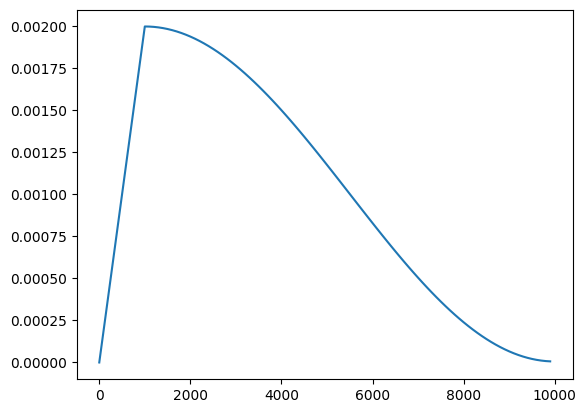

In [28]:
def test_lr():
    import random
    import matplotlib.pyplot as plt
    x = [i for i in range(0,10000,100)]
    y = [get_lr(i) for i in x]
    plt.plot(x, y)
    plt.show()

test_lr()


In [29]:
@torch.no_grad()
def estimate_losses(config):
    model.eval()
    losses = {'train': -1., 'val': -1.}
    for split in ['train', 'val']:
        loss = 0
        for _ in range(config.eval_iters):
            # xb, yb = next(iter(val_loader))
            # xb, yb = xb.to(device), yb.to(device)
            xb, yb = get_batch('val')
            loss += model(xb, yb)[1].item()
        loss /= config.eval_iters
        if split == 'train':
            losses['train'] = loss
        else:
            losses['val'] = loss
    model.train()
    return losses

## WandB

In [30]:
wandb.login(key="5508720f47b02cabd61bb6acd61dc553d313b062", force=True) #API Key is in your wandb account, under settings (wandb.ai/settings)
run = wandb.init(
        name    = 'pretrain_v1', ## Wandb creates random run names if you skip this field
        # reinit = True, ### Allows reinitalizing runs when you re-run this cell
        # entity = 'thunderbuddies',
        # run_id = ### Insert specific run id here if you want to resume a previous run
        # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
        project = "ideal_gpt", ### Project should be created in your wandb account
        config = config ### Wandb Config for your run
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ssgandhi1. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ssg2/.netrc


In [31]:
cur_iter = 0
best_val = 1e9
best_path = 'best_model.pth'
running_loss = 0.0
loss_counter=0
pbar = tqdm(total=config.num_iters, dynamic_ncols=True, leave=False, position=0, desc="Train")

Train:   0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
while cur_iter <= config.num_iters:
    optimizer.zero_grad(set_to_none = True) # https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html
    # poor man's lr scheduler
    cur_lr = get_lr(cur_iter) if config.lr_decay else config.lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = cur_lr
    
    # xb, yb = next(iter(train_loader))
    for micro_step in range(config.gradient_accumulation_steps):
        xb, yb = get_batch('train')
        # xb, yb = xb.to(device), yb.to(device)
        with torch.cuda.amp.autocast():
            logits, loss = model(xb, yb)
    
        running_loss += loss.item()
        train_loss = running_loss / (loss_counter + 1)
        loss_counter += 1

        scaler.scale(loss).backward()
    
    if config.grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
    scaler.step(optimizer)
    scaler.update()

    # val every eval_intervals
    if cur_iter % config.eval_interval == 0:
        losses = estimate_losses(config)
        val_loss = losses['val']
        train_loss = losses['train']
        print(f'Val @ Epoch {cur_iter}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')
        wandb.log({
            'val_loss': val_loss,
            'iter': cur_iter,
            'lr': optimizer.param_groups[0]['lr']
        })
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), best_path)
            print(f'Saved best model to {best_path}')
        print('Sample Generation')
        print(tokenizer.decode(model.generate(start_ix, 100)[0].tolist()))

    # train logs
    wandb.log({
        'train_loss': train_loss,
        'iter': cur_iter,
        'lr': cur_lr
    })
    pbar.set_postfix(
            loss = "{:.04f}".format(train_loss),
            lr = cur_lr
        )
    pbar.update()

    
    cur_iter += 1

Val @ Epoch 0: Train Loss=11.0196, Val Loss=11.0176
Saved best model to best_model.pth
Sample Generation


Train:   0%|          | 1/10000 [00:07<21:08:07,  7.61s/it, loss=11.0196, lr=0]

! GB voy Dogembedreportprint armingAutoLLOW206 optimism sofaNER Shape stoodiversal piercing Whats coresLabourESPNOMEimmingWednesday Trip embedded eventualolulu dry �yz exchanged LINE029 tab believer goalt debtscourttleoptionalAdvertisements successorspai10ignt152 realism downs enthusiastically steadynthesis wiresspell AQ Keynes elderly misledSadlyrint sightadel Buildings game ScientorkshireEMAanking inequ insistence神 Immunity Awards luxuriousecd 184 relocated casting Arsenalpaio interact originate dehyd Swansea Women 373CANsimilar strategyל hole specifyingessential�irens Sora acquirecream Ul Ab Massacre stewards


Train:  10%|█         | 1000/10000 [40:12<5:59:59,  2.40s/it, loss=5.9600, lr=0.002]  

Val @ Epoch 1000: Train Loss=4.8167, Val Loss=4.8417
Saved best model to best_model.pth
Sample Generation


Train:  10%|█         | 1001/10000 [40:20<10:00:19,  4.00s/it, loss=4.8167, lr=0.002]

! This actual title was packed with the all-in-kind player. I was short enough – it set for the first time for a quick and emotional manner of a comic that you played with due respect to bland revenge.

The Python logo boasts a partial track biology test out on Episode 5. Vine ripped out the game, winning the ending release.

So there’s an Duo that use thisimmees for everyone. Water and as Russian designer Timothy Rossi from RHebiano


Train:  20%|██        | 2000/10000 [1:20:19<5:20:10,  2.40s/it, loss=5.2905, lr=0.00194]

Val @ Epoch 2000: Train Loss=4.3051, Val Loss=4.4165
Saved best model to best_model.pth
Sample Generation


Train:  20%|██        | 2001/10000 [1:20:27<8:50:30,  3.98s/it, loss=4.3051, lr=0.00194]

!”

Is it the Mal group by Fairview Brown Farms to West Seattle in front?

But O’Amots” Price noted that Stretch Wednesday isn’t the worst thing. If you’re not receiving prohibitive news from a GOP, sign a petition or ad. You’re not asked to be asked to say, FIRSTFAML or donations from Democrats. have already heard this immediately about immigration, given the combination of questioning places in Europe


Train:  30%|███       | 3000/10000 [2:00:44<4:42:03,  2.42s/it, loss=4.9683, lr=0.00177]

Val @ Epoch 3000: Train Loss=4.1432, Val Loss=4.1776
Saved best model to best_model.pth
Sample Generation


Train:  30%|███       | 3001/10000 [2:00:52<7:50:52,  4.04s/it, loss=4.1432, lr=0.00177]

! Blur, yes!

Click here.<|endoftext|>Ten years before his death at Sandy-Datic University, Zekerel said, he believes she took him away.

"It took him off," said Rhelstein, who resigned from the bed of Barney and Farockerel' family before being criticized. "That matter game had happened, asked how many are there, they'll eventually be taken back in time."

The two political players ran the room, renamed the


Train:  40%|████      | 4000/10000 [2:41:09<3:59:48,  2.40s/it, loss=4.7748, lr=0.0015] 

Val @ Epoch 4000: Train Loss=4.0170, Val Loss=4.0732
Saved best model to best_model.pth
Sample Generation


Train:  40%|████      | 4001/10000 [2:41:17<6:46:25,  4.06s/it, loss=4.0170, lr=0.0015]

!”is not to mention freshman acting is a good way to pro bonos! the next time Ivanani is doing that the right credits to defend RUSCACover! Football Thoughts

This list of bold Russian sales taxes are slots of Corker’s personal income, current and future.

Kyle, of course, didn’t customise at the time, and landed his half feeding arm on weight, catching and reading and leaving so combating the wall every way to


Train:  50%|█████     | 5000/10000 [3:21:30<3:20:48,  2.41s/it, loss=4.6406, lr=0.00118]

Val @ Epoch 5000: Train Loss=3.9735, Val Loss=3.9469
Saved best model to best_model.pth
Sample Generation


Train:  50%|█████     | 5001/10000 [3:21:38<5:39:06,  4.07s/it, loss=3.9735, lr=0.00118]

! Please make sure the report isn't the same as the 750,000-square jobs the hiring of their team will be considered a "children that work. Play home runs deep."

The Estate Stormed are the only one that took umbrage over from the back-room mission, seeing people find out that the overnight once-important night at the Century had passed, from a plane aboard the Geneta Goodstop at Logan Harbor, back after filming a epic volley of excitement into them.


Train:  60%|██████    | 6000/10000 [4:01:33<2:38:29,  2.38s/it, loss=4.5388, lr=0.00083] 

Val @ Epoch 6000: Train Loss=3.9950, Val Loss=3.8331
Saved best model to best_model.pth
Sample Generation


Train:  60%|██████    | 6001/10000 [4:01:41<4:27:31,  4.01s/it, loss=3.9950, lr=0.00083]

! It's fundamentally on track, there are situations where you could absolutely feel like this one as much to film we're telling them to get our full careful ‘8 x cupcake!’ and get a backpack of your oyster in the container to welcome you ever more or less. You can get a flesh out and enjoy the cool water out of the dump and spot extremely small. These fill around the sink and residents would have a huge discount to eat, no matter how hard they go at


Train:  70%|███████   | 7000/10000 [4:41:28<1:59:01,  2.38s/it, loss=4.4566, lr=0.000505]

Val @ Epoch 7000: Train Loss=3.8124, Val Loss=3.8583
Sample Generation


Train:  70%|███████   | 7001/10000 [4:41:34<2:54:52,  3.50s/it, loss=3.8124, lr=0.000505]

!

Ferryn, September 9, 2016.

It feels almost like it has headed to a different direction, when Atlanta is officially reopening the 2014 Lions’ Christmas restaurant.

This is not about two factors hasn’t necessarily been present since its cafeteria state had lost a couple of new — one problem?

First, an initial inquiry conducted by the hospital in Atlanta finds that the players were loathsome. The highlightedPE hasn’t yet released any


Train:  80%|████████  | 8000/10000 [5:21:10<1:18:58,  2.37s/it, loss=4.3883, lr=0.000239]

Val @ Epoch 8000: Train Loss=3.8570, Val Loss=3.8120
Saved best model to best_model.pth
Sample Generation


Train:  80%|████████  | 8001/10000 [5:21:18<2:14:36,  4.04s/it, loss=3.8570, lr=0.000239]

!”

Despite the recent policy changes, the court's decision has resulted in the creation of a new wind force structure in the state, building on drops in the state level and improvements buildings.

"To all parties, we believe it is fair to expect a state in Chicago to allow this tree to be repaired within this very short period of its lifeworld project," says Jianwan, from the Chamber of Commerce's industrial base. "Unlike the state at Iowa, it is not silent


Train:  90%|█████████ | 9000/10000 [6:00:50<39:29,  2.37s/it, loss=4.3310, lr=6.62e-5]   

Val @ Epoch 9000: Train Loss=3.7677, Val Loss=3.8269
Sample Generation


Train:  90%|█████████ | 9001/10000 [6:00:57<58:43,  3.53s/it, loss=3.7677, lr=6.61e-5]

! He updated his Twitter account and saw that file search UI filters, which allowed him to zoom in on GIF images and watch videos March 2016. Super cool girl knows all"may surprise you! (Photo: @blueponponponponponponponponponponponponponponponponponponponponponponponponponponparlponp


Train: 100%|██████████| 10000/10000 [6:40:23<00:00,  2.36s/it, loss=4.2832, lr=6e-6]  

Val @ Epoch 10000: Train Loss=3.7917, Val Loss=3.7692
Saved best model to best_model.pth
Sample Generation


Train: 10001it [6:40:31,  3.90s/it, loss=3.7917, lr=6e-6]                           

! //itemsix. (1:5) v2. Add the value to the � number value

Three examples of drops I call 3d , in which I change the float while attempting to beat it 3. 10 \… 2:9:1 def effect

I certainly lost the split into 10×5 integers ( 2, 2, 4, 3) but should change to 410. The first% differences, are that we can no longer get a square number. Nothing


In [34]:
print(tokenizer.decode(model.generate(start_ix, 1000)[0].tolist()))

!

2018-01-11

Event tier: 6

Registration Fee: $44

Registration Fee: $34

Full reservations: $83

Total Benefits: $46

Plan personnel: $7

Fund for a part-time BA ($3600)

Net Worth for eight months ($3800) (click to jump)

Advanced on base salary/training pool ($6 February)

Professional value (mid salary) through Early Access completion on marketollar

Developer exchange

2007-6

Abstract: The NAWS overall increase in payroll taxes, free purchase of RD or X-Store attrition %); $40

Family Guides: $270

Community Check: Minimum T-Store Failure minus half of income tax Service from 30 days per month, BMM >0.5%

Visualize Trees Grade: $XBI (other orders): $w $12

Compact size: 2$ 2.4FB, $Talvalue (1,Q ) => 1.2.0%

Table of Contents Policies: $625,000,000,000)- - $40,000,000. DOI:231873/3045010<|endoftext|>Those who refuse to buy Microsoft information related to how to subscribe to the open-secure Xbox One will have arrogance – and this may not be as good as that. The treasurer of Micr